# EPI Trimming
In this notebook, we are going to do some trimming of the EVs in order to account for the differences in start and stop times for some subjects. We were able to figure out the correct starting time by looking at the number of TRs that are recorded during the last fixation screen for each participant. If there are less than 7 TRs recorded, we need to add the difference to the number of TRs that we trim at the beginning so that we can be sure that everyone's images line up with the EVs appropriately. The trimming procedure is outlined in the excel file Mazie created. Basically, we need to take the 

In [1]:
import os

In [2]:
import glob
import pandas as pd
import numpy as np
from os.path import join as opj
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.pipeline import Node, MapNode, Workflow

from nipype.interfaces.utility import Function
from nipype.algorithms.misc import Gunzip
from nipype.interfaces import fsl, afni
from nipype import SelectFiles, IdentityInterface

200922-11:25:14,321 nipype.utils INFO:
	 Running nipype version 1.5.0-rc1 (latest: 1.5.1)


In [40]:
base_dir = "/lustre/scratch/mzielins/collab_files"
working_dir = opj(base_dir + "/preproc")
output_dir = opj(base_dir + "/preproc" + "/trimmed")

subnums = list(range(1,31))
sub_list = [f"{s:02d}" for s in subnums]

In [41]:
sub_list

['01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '26',
 '27',
 '28',
 '29',
 '30']

## Getting the layout of the files that I will need to plug into the workflow

I'm going to use `SelectFiles()` to get all of the data from the fmriprep outputs.

In [42]:
templates = {
    "func": "preproc/fmriprep/sub-{sub_id}/func/sub-{sub_id}_task-images_run-*_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz",
}

sf = Node(interface=SelectFiles(templates, infields=["sub_id"], outfields=["func"], sort_filelist=True), name="sf")

sf.inputs.base_directory = base_dir
sf.inputs.template = "*"

## Function Creation
### Iteration
Creating an `IdentityInterface` node that will let me iterate over all subjects.

In [43]:
infosource = Node(IdentityInterface(fields=["sub_id"]), name="infosource")
infosource.iterables = [("sub_id", sub_list)]

### UnZipping

In [44]:
gunzip = MapNode(Gunzip(), name="gunzip", iterfield=["in_file"])

### Trimming

Since we will have a variable trim depending on whether or not the scan was started at the correct time, I will need to set up a `function node` to take in information about the subject number, and change the timming depending on that. 

In [45]:
infile = "/lustre/scratch/mzielins/collab_files/preproc/fmriprep/sub-01/func/sub-01_task-images_run-1_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz"

In [46]:
results = fsl.ExtractROI(in_file = infile, t_min = 5, t_size = 191)

In [47]:
extract = Node(fsl.ExtractROI(in_file = infile, t_min=4, t_size=-1, output_type='NIFTI'), name="extract")
extract.run().outputs.roi_file

200922-11:37:32,713 nipype.workflow INFO:
	 [Node] Setting-up "extract" in "/tmp/tmp764ca0dn/extract".
200922-11:37:32,720 nipype.workflow INFO:
	 [Node] Running "extract" ("nipype.interfaces.fsl.utils.ExtractROI"), a CommandLine Interface with command:
fslroi /lustre/scratch/mzielins/collab_files/preproc/fmriprep/sub-01/func/sub-01_task-images_run-1_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz /tmp/tmp764ca0dn/extract/sub-01_task-images_run-1_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold_roi.nii 4 -1
200922-11:37:44,582 nipype.workflow INFO:
	 [Node] Finished "extract".


'/tmp/tmp764ca0dn/extract/sub-01_task-images_run-1_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold_roi.nii'

In [86]:
test = "/lustre/scratch/mzielins/collab_files/preproc/fmriprep/sub-01/func/sub-01_task-images_run-1_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold.nii.gz"
test.split("_")[-4].split("-")[1]

'1'

In [103]:
def trimmer(sub_id, in_file):
    from nipype.interfaces import fsl
    from nipype.pipeline import Node
    import pandas as pd
    import os
    
    run = in_file.split("_")[-4].split("-")[1]
    
    sub_id = str(sub_id)
    
    if sub_id in ["13", "17", "24", "26", "28"] and run == "2":
        tmin = 13
        tsize = 184
    else:
        tmin = 5
        tsize = 191

    trimmed_file = fsl.ExtractROI(in_file=in_file, t_min=tmin, t_size=tsize, output_type="NIFTI").run().outputs.roi_file
    
    return trimmed_file

epi_trim = MapNode(
    name="epi_trim", 
    infields = ["sub_id", "in_file"],
    iterfield="in_file",
    interface = Function(function=trimmer, input_names=["sub_id", "in_file"], output_names="epis_trimmed")
)

In [104]:
datasink = Node(DataSink(base_directory = output_dir), name="datasink", parameterization=True)

regex_subs = [
    ("_sub_id_\d+/", ""), 
    ("_epi_trim\d/", "")
    ]

datasink.inputs.regexp_substitutions = regex_subs
# datasink.inputs.container = "sub_id"

## Workflow Creation
Creating a workflow to pull in the files and trim them 

In [105]:
postproc = Workflow(name="postproc", base_dir=working_dir)

In [106]:
# Connect all the nodes
postproc.connect(
    [
        (infosource, sf, [("sub_id", "sub_id")]),
        (sf, gunzip, [("func", "in_file")]),
        (infosource, epi_trim, [("sub_id", "sub_id")]),
        (gunzip, epi_trim, [("out_file", "in_file")]),
        (epi_trim, datasink, [("epis_trimmed", "@trimmed_files")])
    ]
)

200922-12:18:35,297 nipype.workflow INFO:
	 Generated workflow graph: /lustre/scratch/mzielins/collab_files/preproc/postproc/graph.png (graph2use=colored, simple_form=False).


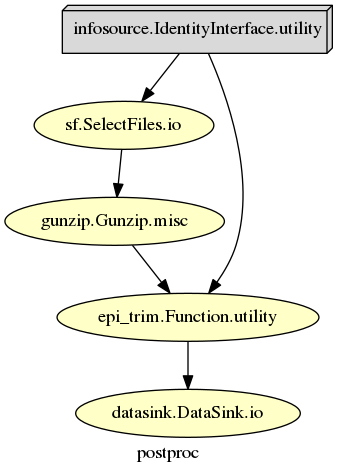

In [107]:
# Create preproc output graph
from IPython.display import Image

postproc.write_graph(graph2use="colored", format="png", simple_form=False)

# Visualize the graph
Image(filename=opj(base_dir + "/preproc/postproc/graph.png"), width=500)

## Running the Workflow

In [108]:
postproc.config['execution'] = {'hash_method': 'timestamp'}
postproc.run(plugin="MultiProc", plugin_args={"n_procs": 4})

200922-12:18:41,854 nipype.workflow INFO:
	 Workflow postproc settings: ['check', 'execution', 'logging', 'monitoring']
200922-12:18:42,158 nipype.workflow INFO:
	 Running in parallel.
200922-12:18:42,316 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 30 jobs ready. Free memory (GB): 169.92/169.92, Free processors: 4/4.
200922-12:18:42,490 nipype.workflow INFO:
	 [Node] Setting-up "postproc.sf" in "/lustre/scratch/mzielins/collab_files/preproc/postproc/_sub_id_30/sf".
200922-12:18:42,492 nipype.workflow INFO:
	 [Node] Setting-up "postproc.sf" in "/lustre/scratch/mzielins/collab_files/preproc/postproc/_sub_id_28/sf".
200922-12:18:42,489 nipype.workflow INFO:
	 [Node] Setting-up "postproc.sf" in "/lustre/scratch/mzielins/collab_files/preproc/postproc/_sub_id_29/sf".
200922-12:18:42,495 nipype.workflow INFO:
	 [Node] Setting-up "postproc.sf" in "/lustre/scratch/mzielins/collab_files/preproc/postproc/_sub_id_27/sf".
200922-12:18:42,734 nipype.workflow INFO:
	 [Node] Running "sf" 

RuntimeError: Workflow did not execute cleanly. Check log for details

In [99]:
import nibabel as nib
files = glob.glob("/lustre/scratch/mzielins/collab_files/preproc/trimmed/*")
files[0]

'/lustre/scratch/mzielins/collab_files/preproc/trimmed/sub-29_task-images_run-1_space-MNI152NLin6Asym_desc-smoothAROMAnonaggr_bold_roi.nii'

In [100]:
test = nib.load(files[1]).header

In [101]:
print(test.get_data_shape())

(91, 109, 91, 191)


In [102]:
for file in files:
    hdr = nib.load(file).header
    dim4 = hdr.get_data_shape()[-1]
    print(dim4)

191
191
183
191
191
191
191
191
191
191
191
191
191
191
183
191
191
191
191
191
191
191
191
191
183
191
191
191
191
183
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
191
183
191
